In [15]:
using Qaintessent
using Qaintellect
using LinearAlgebra
using Flux
using IterTools: ncycle

In [16]:
using Plots
using LaTeXStrings

In [17]:
n = 5

# graph edges corresponding to the above graph
edges = [(0, 1), (1, 2), (1, 3), (2, 4), (3, 4)];

In [18]:
# define uniform superposition state s
s_uni = fill(1/√(2^n) + 0.0im, 2^n);

In [19]:
function assemble_time_step_gates(p::Int, n::Int, edges::Vector{Tuple{Int,Int}})
    cgs = CircuitGate[]
    for _ in 1:p
        # C operator
        for e in edges
            # circuit gate uses 1-based indexing
            push!(cgs, circuit_gate(e[1] + 1, e[2] + 1, EntanglementZZGate(0.01*randn())))
        end
        # B operator
        for j in 1:n
           push!(cgs, circuit_gate(j, RxGate(0.01*randn())))
        end
    end
    return cgs
end

assemble_time_step_gates (generic function with 1 method)

In [20]:
# create measurement operator representing C
Cmat = zeros(2^n, 2^n)
for edge in edges
    k1 = circuit_gate(edge[1] + 1, ZGate())
    k2 = circuit_gate(edge[2] + 1, ZGate())
    Cmat += 0.5*(I - sparse_matrix([k1, k2], n))
end
@show(diag(Cmat))
Cop = MeasurementOperator(Cmat, Tuple(1:n));

diag(Cmat) = Complex{Float64}[0.0 + 0.0im, 1.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 4.0 + 0.0im, 5.0 - 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 5.0 - 0.0im, 4.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 3.0 + 0.0im, 2.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im]


In [21]:
# example
circ = Circuit{n}(assemble_time_step_gates(2, n, edges), [Cop])


    5 ————————————————————□—————□————[Rx]———————————————□—————□————[Rx]—
                          |     |                       |     |         
    4 ——————————————□———————————□————[Rx]—————————□———————————□————[Rx]—
                    |     |                       |     |               
    3 ————————□———————————□————[Rx]—————————□———————————□————[Rx]———————
              |     |                       |     |                     
    2 ——□—————□—————□——————————[Rx]———□—————□—————□——————————[Rx]———————
        |                             |                                 
    1 ——□——————————————————————[Rx]———□——————————————————————[Rx]———————


In [8]:
# example: apply circuit gates and compute expectation value
apply(circ, s_uni)

1-element Array{Float64,1}:
 2.4999875330447376

In [9]:
# first attempt with p = 1

circ1 = Circuit{n}(assemble_time_step_gates(1, n, edges), [Cop])

# gather parameters from circuit
paras = Flux.params(circ1)

# there is not actually any input data for training
data = ncycle([()], 500)

# define optimizer
opt = Descent(0.5)

# define evaluation function
evalcb() = @show(apply(circ1, s_uni))

# perform minimization with the negated target function to achieve maximization
Flux.train!(() -> -apply(circ1, s_uni)[1], paras, data, opt, cb=Flux.throttle(evalcb, 0.5))

apply(circ1, s_uni) = [2.50024316170983]
apply(circ1, s_uni) = [3.999999999999928]
apply(circ1, s_uni) = [3.9999999999999982]
apply(circ1, s_uni) = [3.999999999999999]
apply(circ1, s_uni) = [3.999999999999999]


In [10]:

# corresponding optimized quantum wavefunction
ψ1 = apply(circ1.moments, s_uni);

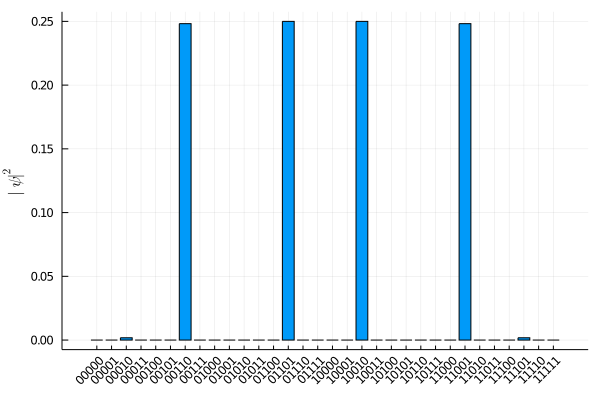

In [11]:
tags = [join(reverse(digits(i, pad=n, base=2))) for i in 0:2^n-1]
bar(tags, abs2.(ψ1), xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false)

In [12]:
# increase number of layers to p = 2

circ2 = Circuit{n}(assemble_time_step_gates(2, n, edges), [Cop])

# gather parameters from circuit
paras = Flux.params(circ2)

# there is not actually any input data for training
data = ncycle([()], 500)

# define optimizer
opt = Descent(0.5)

# define evaluation function
evalcb() = @show(apply(circ2, s_uni))

# perform minimization with the negated target function to achieve maximization
Flux.train!(() -> -apply(circ2, s_uni)[1], paras, data, opt, cb=Flux.throttle(evalcb, 0.5))

apply(circ2, s_uni) = [2.500623239352105]
apply(circ2, s_uni) = [4.998179842003981]
apply(circ2, s_uni) = [4.999932534723461]
apply(circ2, s_uni) = [4.999997875828267]
apply(circ2, s_uni) = [4.999999913089275]
apply(circ2, s_uni) = [4.999999996216737]
apply(circ2, s_uni) = [4.999999999863038]
apply(circ2, s_uni) = [4.999999999995612]
apply(circ2, s_uni) = [4.999999999999822]
apply(circ2, s_uni) = [4.999999999999992]


In [13]:
# corresponding optimized quantum wavefunction
ψ2 = apply(circ2.moments, s_uni);

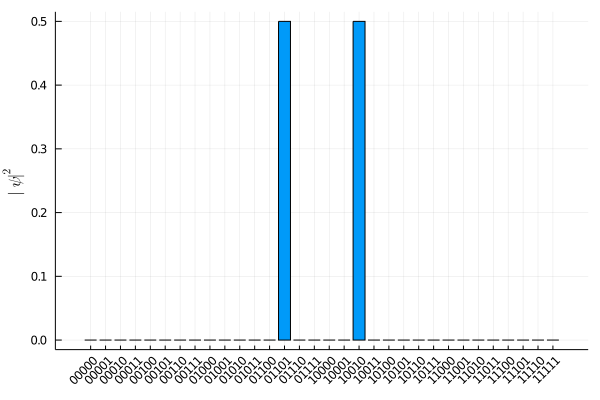

In [14]:
tags = [join(reverse(digits(i, pad=n, base=2))) for i in 0:2^n-1]
bar(tags, abs2.(ψ2), xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false)